### Analyze metadata predictions

In [85]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import typing as t
import pickle
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the logging level

# Create a handler
handler = logging.StreamHandler()

# Create and set a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

# To suppress the stupid AnnData warning ...
warnings.filterwarnings("ignore", category=UserWarning, message="Transforming to str index.")

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext
from cellarium.ml.utilities.inference.metadata_benchmarking.calculate_metrics import \
    calculate_metrics_for_prediction_output

In [86]:
ROOT_PATH = "/home/mehrtash/data"
METADATA_PREDICTIONS_ROOT_PATH = os.path.join(ROOT_PATH, "data", "metadata_predictions")
PREFIX_LIST = [
    "10M_001_bs1536",
    "19M_001_bs2048",
    "30M_001_bs2560",
    "100M_long_run_last"
]
VAL_ADATA_IDX_RANGE = np.arange(1, 111)
N_HOPS_DICT = {
    'cell_type': 3,
    'development_stage': 3,
    'disease': 3,
    'tissue': 3,
    'sex': 0,
}

def load_predictions_anndata(val_adata_idx: int, prefix_idx: int) -> sc.AnnData:
    path = os.path.join(
        METADATA_PREDICTIONS_ROOT_PATH,
        PREFIX_LIST[prefix_idx],
        f"extract_{VAL_ADATA_IDX_RANGE[val_adata_idx]}_metadata_prediction_scores.h5ad")
    return sc.read_h5ad(path)

In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm

results = defaultdict(list)
eps = 1e-8

for prefix_idx in tqdm(range(len(PREFIX_LIST))):
    prefix = PREFIX_LIST[prefix_idx]
    for val_adata_idx in tqdm(range(len(VAL_ADATA_IDX_RANGE))):
        val_adata_id = VAL_ADATA_IDX_RANGE[val_adata_idx]
        meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx)

        results["prefix"].append(prefix)
        results["val_adata_id"].append(val_adata_id)

        for key in ["cell_type", "disease", "development_stage", "tissue", "sex"]:
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}
            for n_hops in range(N_HOPS_DICT[key] + 1):
                metric = f"{key}_hop_{n_hops}"
                sensitivity_col_name = f"{metric}_sensitivity"
                specificity_col_name = f"{metric}_specificity"
                try:
                    new_obs = meta_adata.obs.dropna(subset=[sensitivity_col_name, specificity_col_name])
                    if len(new_obs) == 0:
                        print(f"Error processing {key} for val_adata_id {val_adata_id} and prefix {prefix}")
                    recall = new_obs[sensitivity_col_name].values.mean()
                    precision = new_obs[specificity_col_name].values.mean()
                    f1 = 2 * (precision * recall) / (precision + recall)
                    logodds = np.log(new_obs[sensitivity_col_name].values + eps) - np.log(1 - new_obs[specificity_col_name].values + eps)
                    logodds = logodds.mean()
                except:
                    print(f"Error processing {key} for val_adata_id {val_adata_id} and prefix {prefix}")
                    recall = np.nan
                    precision = np.nan
                    f1 = np.nan
                    logodds = np.nan

                # truth_names = meta_adata.obs[f"{key}_ontology_term_id"].values
                # truth_indices = np.asarray(list(map(mapper.get, truth_names)))
                # weights = np.ones_like(truth_indices)
                # bad_indices = [idx for idx in range(len(truth_names)) if truth_names[idx] not in mapper]
                # weights[bad_indices] = 0
                # truth_indices[bad_indices] = 0
                # loss = - weights * meta_adata.obsm[f"{key}_class_logits"][np.arange(len(meta_adata)), truth_indices.astype(int)]
                # loss = loss.mean()

                # results[f"{metric}_loss"].append(loss)
                results[f"{metric}_recall"].append(recall)
                results[f"{metric}_precision"].append(precision)
                results[f"{metric}_f1"].append(f1)
                results[f"{metric}_logodds"].append(logodds)

In [92]:
results_df = pd.DataFrame(results)

/var/tmp/ipykernel_13649/2074687837.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens = cm.get_cmap('Greens', len(cell_metrics))
/var/tmp/ipykernel_13649/2074687837.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = cm.get_cmap('Reds', len(disease_metrics))
/var/tmp/ipykernel_13649/2074687837.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap('Blues', len(tissue_metrics))
/var/tmp/ipykernel_13649/2074687837.py:68: MatplotlibDeprecationW

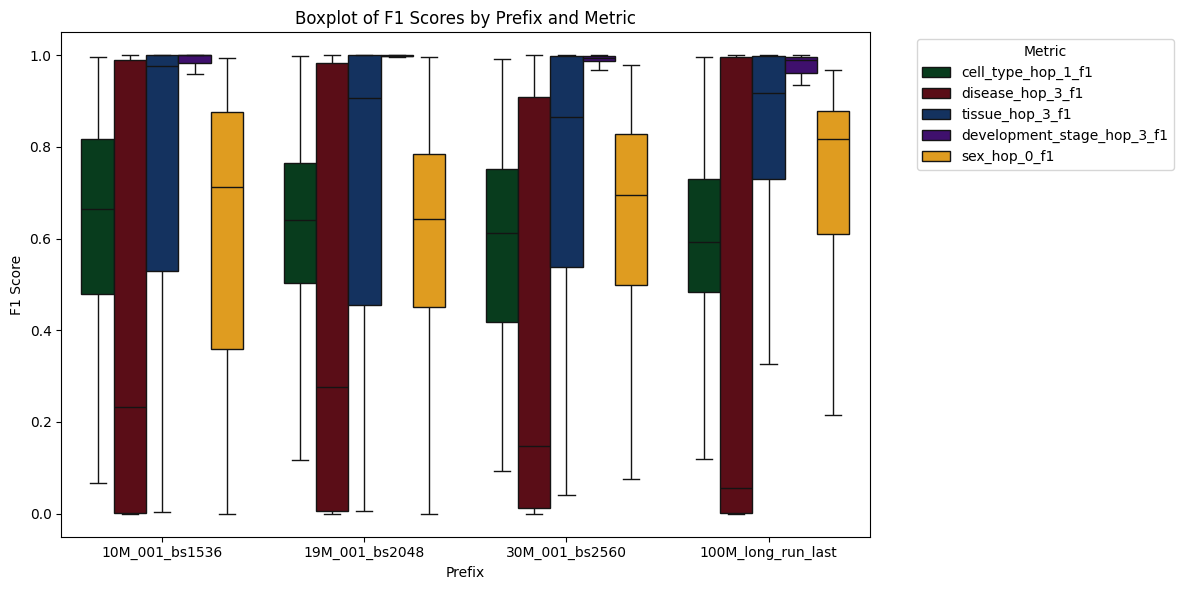

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Suppose your dataframe is named `df` and PREFIX_LIST is defined, e.g.,
# PREFIX_LIST = ['prefixA', 'prefixB', 'prefixC', 'prefixD']

# Define the list of metric columns you want to plot:
# metrics = [
#     'cell_type_hop_0_f1', 'cell_type_hop_1_f1', 'cell_type_hop_2_f1', 'cell_type_hop_3_f1',
#     'disease_hop_0_f1', 'disease_hop_1_f1', 'disease_hop_2_f1', 'disease_hop_3_f1',
#     'tissue_hop_0_f1', 'tissue_hop_1_f1', 'tissue_hop_2_f1', 'tissue_hop_3_f1',
#     'development_stage_hop_0_f1', 'development_stage_hop_1_f1', 'development_stage_hop_2_f1', 'development_stage_hop_3_f1',
#     'sex_hop_0_f1'
# ]

metrics = [
    'cell_type_hop_1_f1',
    'disease_hop_3_f1',
    'tissue_hop_3_f1',
    'development_stage_hop_3_f1',
    'sex_hop_0_f1'
]


# Melt the dataframe so that each row corresponds to one (prefix, metric, f1 value) triple.
df = results_df
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'], 
    value_vars=metrics, 
    var_name='metric', 
    value_name='f1'
)

# Drop NaN values from the f1 column.
df_long = df_long.dropna(subset=['f1'])

# (Optional) Create a new column for the metric group.
df_long['metric_group'] = df_long['metric'].apply(lambda x: x.split('_hop')[0])

# Define the desired order for the metrics. This will also control the order in the legend.
metric_order = metrics  # assuming you want the order as defined above

# Create a palette mapping so that each metric group gets its own colormap.
palette = {}

# For cell type (using a Greens gradient):
cell_metrics = [m for m in metrics if m.startswith('cell_type')]
greens = cm.get_cmap('Greens', len(cell_metrics))
for i, m in enumerate(cell_metrics):
    palette[m] = greens(i)

# For disease (using a Reds gradient):
disease_metrics = [m for m in metrics if m.startswith('disease')]
reds = cm.get_cmap('Reds', len(disease_metrics))
for i, m in enumerate(disease_metrics):
    palette[m] = reds(i)

# For tissue (using a Blues gradient):
tissue_metrics = [m for m in metrics if m.startswith('tissue')]
blues = cm.get_cmap('Blues', len(tissue_metrics))
for i, m in enumerate(tissue_metrics):
    palette[m] = blues(i)

# For development stage (using a Purples gradient):
dev_metrics = [m for m in metrics if m.startswith('development_stage')]
purples = cm.get_cmap('Purples', len(dev_metrics))
for i, m in enumerate(dev_metrics):
    palette[m] = purples(i)

# For sex (only one metric, assign a single color):
sex_metrics = [m for m in metrics if m.startswith('sex')]
if sex_metrics:
    palette[sex_metrics[0]] = 'orange'

# Create the boxplot.
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='prefix',
    y='f1',
    hue='metric',
    data=df_long,
    order=PREFIX_LIST,       # enforce prefix order
    hue_order=metric_order,  # enforce the metric order
    palette=palette,
    showfliers=False         # do not show outliers
)

plt.xlabel('Prefix')
plt.ylabel('F1 Score')
plt.title('Boxplot of F1 Scores by Prefix and Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Metric')
plt.tight_layout()
plt.show()


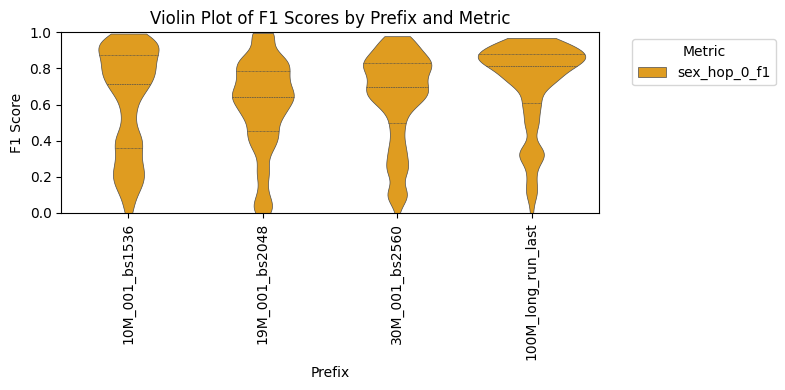

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Assume your dataframe is named `df` and PREFIX_LIST is defined, e.g.,
# PREFIX_LIST = ['prefixA', 'prefixB', 'prefixC', 'prefixD']

# Define the list of metric columns:
metrics = [
    # 'cell_type_hop_0_f1', 'cell_type_hop_1_f1', 'cell_type_hop_2_f1', 'cell_type_hop_3_f1',
    # 'disease_hop_0_f1', 'disease_hop_1_f1', 'disease_hop_2_f1', 'disease_hop_3_f1',
    # 'tissue_hop_0_f1', 'tissue_hop_1_f1', 'tissue_hop_2_f1', 'tissue_hop_3_f1',
    # 'development_stage_hop_0_f1', 'development_stage_hop_1_f1', 'development_stage_hop_2_f1', 'development_stage_hop_3_f1',
    'sex_hop_0_f1'
]

# Reshape the dataframe to long format.
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'], 
    value_vars=metrics, 
    var_name='metric', 
    value_name='f1'
)

# Drop NaN values.
df_long = df_long.dropna(subset=['f1'])

# (Optional) Create a metric group column.
df_long['metric_group'] = df_long['metric'].apply(lambda x: x.split('_hop')[0])

# Maintain the desired metric order.
metric_order = metrics

# Create a custom palette, sampling from the middle of each colormap.
palette = {}

# For cell type metrics using Greens.
cell_metrics = [m for m in metrics if m.startswith('cell_type')]
n = len(cell_metrics)
for i, m in enumerate(cell_metrics):
    palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))

# For disease metrics using Reds.
disease_metrics = [m for m in metrics if m.startswith('disease')]
n = len(disease_metrics)
for i, m in enumerate(disease_metrics):
    palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))

# For tissue metrics using Blues.
tissue_metrics = [m for m in metrics if m.startswith('tissue')]
n = len(tissue_metrics)
for i, m in enumerate(tissue_metrics):
    palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))

# For development stage metrics using Purples.
dev_metrics = [m for m in metrics if m.startswith('development_stage')]
n = len(dev_metrics)
for i, m in enumerate(dev_metrics):
    palette[m] = cm.get_cmap('Purples')((i + 1) / (n + 1))

# For sex metric, assign a single color.
sex_metrics = [m for m in metrics if m.startswith('sex')]
if sex_metrics:
    palette[sex_metrics[0]] = 'orange'

# Create the violin plot with further reduced bandwidth.
plt.figure(figsize=(8, 4))
sns.violinplot(
    x='prefix',
    y='f1',
    hue='metric',
    data=df_long,
    order=PREFIX_LIST,       # enforce prefix order
    hue_order=metric_order,  # enforce metric order
    palette=palette,
    inner='quartile',        # display quartile markers
    linewidth=0.5,           # thinner outline lines
    cut=0,                   # do not extend beyond data range
    bw_adjust=0.5            # further reduce smoothing
)

plt.xlabel('Prefix')
plt.ylabel('F1 Score')
plt.title('Violin Plot of F1 Scores by Prefix and Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Metric')
plt.ylim(0, 1)  # explicitly restrict y-axis to [0, 1]
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/var/tmp/ipykernel_13649/137335904.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/137335904.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/137335904.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/137335904.py:60: MatplotlibDeprec

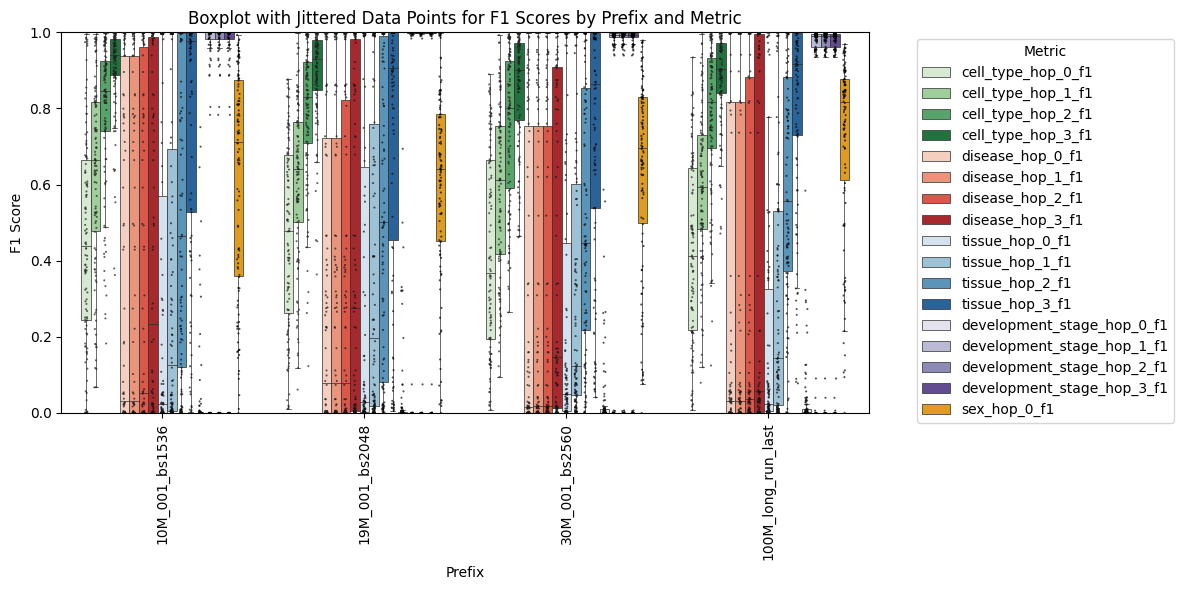

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Assume your dataframe is named `df` and PREFIX_LIST is defined, e.g.,
# PREFIX_LIST = ['prefixA', 'prefixB', 'prefixC', 'prefixD']

# Define the list of metric columns:
metrics = [
    'cell_type_hop_0_f1', 'cell_type_hop_1_f1', 'cell_type_hop_2_f1', 'cell_type_hop_3_f1',
    'disease_hop_0_f1', 'disease_hop_1_f1', 'disease_hop_2_f1', 'disease_hop_3_f1',
    'tissue_hop_0_f1', 'tissue_hop_1_f1', 'tissue_hop_2_f1', 'tissue_hop_3_f1',
    'development_stage_hop_0_f1', 'development_stage_hop_1_f1', 'development_stage_hop_2_f1', 'development_stage_hop_3_f1',
    'sex_hop_0_f1'
]

# Reshape the dataframe to long format.
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'], 
    value_vars=metrics, 
    var_name='metric', 
    value_name='f1'
)

# Drop NaN values.
df_long = df_long.dropna(subset=['f1'])

# (Optional) Create a metric group column.
df_long['metric_group'] = df_long['metric'].apply(lambda x: x.split('_hop')[0])

# Maintain the desired metric order.
metric_order = metrics

# Create a custom palette, sampling from the middle of each colormap.
palette = {}

# For cell type metrics using Greens.
cell_metrics = [m for m in metrics if m.startswith('cell_type')]
n = len(cell_metrics)
for i, m in enumerate(cell_metrics):
    palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))

# For disease metrics using Reds.
disease_metrics = [m for m in metrics if m.startswith('disease')]
n = len(disease_metrics)
for i, m in enumerate(disease_metrics):
    palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))

# For tissue metrics using Blues.
tissue_metrics = [m for m in metrics if m.startswith('tissue')]
n = len(tissue_metrics)
for i, m in enumerate(tissue_metrics):
    palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))

# For development stage metrics using Purples.
dev_metrics = [m for m in metrics if m.startswith('development_stage')]
n = len(dev_metrics)
for i, m in enumerate(dev_metrics):
    palette[m] = cm.get_cmap('Purples')((i + 1) / (n + 1))

# For sex metric, assign a single color.
sex_metrics = [m for m in metrics if m.startswith('sex')]
if sex_metrics:
    palette[sex_metrics[0]] = 'orange'

# Create the plot with boxplot and jittered points.
plt.figure(figsize=(12, 6))

# Plot the boxplot without outliers.
ax = sns.boxplot(
    x='prefix',
    y='f1',
    hue='metric',
    data=df_long,
    order=PREFIX_LIST,       # enforce prefix order
    hue_order=metric_order,  # enforce metric order
    palette=palette,
    showfliers=False,        # do not show outliers
    linewidth=0.5            # thinner lines
)

# Overlay the actual points with jitter.
sns.stripplot(
    x='prefix',
    y='f1',
    hue='metric',
    data=df_long,
    order=PREFIX_LIST,
    hue_order=metric_order,
    # palette=palette,
    dodge=True,    # position points within each box category
    jitter=True,   # add jitter for better visibility
    marker='.',
    color='black',
    alpha=0.7,
    size=3
)

# Remove duplicate legend entries.
handles, labels = ax.get_legend_handles_labels()
n_handles = len(handles) // 2
ax.legend(handles[:n_handles], labels[:n_handles],
          bbox_to_anchor=(1.05, 1), loc='upper left', title='Metric')

plt.xlabel('Prefix')
plt.ylabel('F1 Score')
plt.title('Boxplot with Jittered Data Points for F1 Scores by Prefix and Metric')
plt.ylim(0, 1)  # restrict y-axis to [0, 1]
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/var/tmp/ipykernel_13649/1115505766.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/1115505766.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/1115505766.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))
/var/tmp/ipykernel_13649/1115505766.py:55: MatplotlibDe

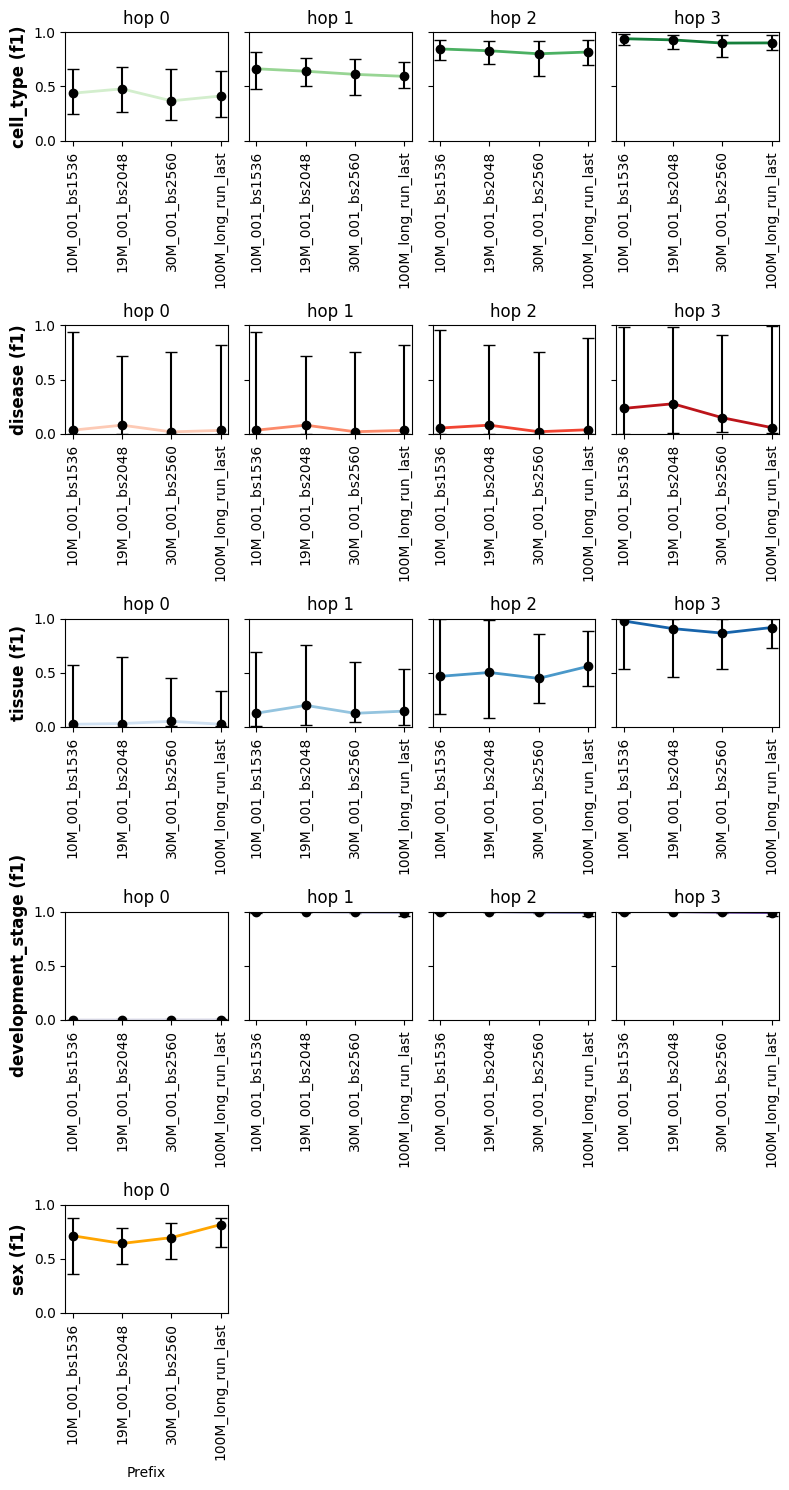

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -------------------------------
# User-specified options:
# Choose which metric to plot: 'f1', 'sensitivity', or 'specificity'
value_to_plot = 'f1'  
# Flag to select summary statistic: True uses mean/std, False uses median/IQR.
use_mean = False  
# -------------------------------

# Define metric groups and available hops.
# For 'sex', only hop 0 is available.
metric_groups = {
    'cell_type': [0, 1, 2, 3],
    'disease': [0, 1, 2, 3],
    'tissue': [0, 1, 2, 3],
    'development_stage': [0, 1, 2, 3],
    'sex': [0]
}

# Build the list of metric columns (e.g., "cell_type_hop_0_f1")
selected_metrics = []
for group, hops in metric_groups.items():
    for hop in hops:
        selected_metrics.append(f"{group}_hop_{hop}_{value_to_plot}")

# Precompute a color palette for each metric column.
palette = {}

# For cell_type: use Greens.
cell_metrics = [f"cell_type_hop_{hop}_{value_to_plot}" for hop in metric_groups['cell_type']]
n = len(cell_metrics)
for i, m in enumerate(cell_metrics):
    palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))

# For disease: use Reds.
disease_metrics = [f"disease_hop_{hop}_{value_to_plot}" for hop in metric_groups['disease']]
n = len(disease_metrics)
for i, m in enumerate(disease_metrics):
    palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))

# For tissue: use Blues.
tissue_metrics = [f"tissue_hop_{hop}_{value_to_plot}" for hop in metric_groups['tissue']]
n = len(tissue_metrics)
for i, m in enumerate(tissue_metrics):
    palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))

# For development_stage: use Purples.
dev_metrics = [f"development_stage_hop_{hop}_{value_to_plot}" for hop in metric_groups['development_stage']]
n = len(dev_metrics)
for i, m in enumerate(dev_metrics):
    palette[m] = cm.get_cmap('Purples')((i + 1) / (n + 1))

# For sex: assign a fixed color (e.g., orange).
sex_metrics = [f"sex_hop_{hop}_{value_to_plot}" for hop in metric_groups['sex']]
for m in sex_metrics:
    palette[m] = 'orange'

# Melt the dataframe into long format for the selected metrics.
# Assume your original dataframe is named `df`.
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'],
    value_vars=selected_metrics,
    var_name='metric',
    value_name=value_to_plot
)
# Drop any rows with NaN values for the chosen metric.
df_long = df_long.dropna(subset=[value_to_plot])

# Determine grid size: one row per metric group, columns = max hops among groups.
n_rows = len(metric_groups)
max_cols = max(len(hops) for hops in metric_groups.values())

fig, axes = plt.subplots(n_rows, max_cols, figsize=(2 * max_cols, 3 * n_rows), sharey=True)

# Loop over each metric group (row) and each hop (column).
for row_idx, (group, hops) in enumerate(metric_groups.items()):
    for col_idx in range(max_cols):
        # Turn off extra panels.
        if col_idx >= len(hops):
            axes[row_idx, col_idx].axis('off')
            continue

        hop = hops[col_idx]
        metric_name = f"{group}_hop_{hop}_{value_to_plot}"
        ax = axes[row_idx, col_idx]

        # Filter data for the current metric and drop any NaNs.
        df_metric = df_long[df_long['metric'] == metric_name].dropna(subset=[value_to_plot])

        # Compute summary statistics per prefix.
        if use_mean:
            stats = df_metric.groupby('prefix')[value_to_plot].agg(['mean', 'std']).reindex(PREFIX_LIST)
            y_vals = stats['mean']
            y_err = stats['std']
        else:
            stats = df_metric.groupby('prefix').agg(
                median=(value_to_plot, np.median),
                q1=(value_to_plot, lambda x: x.quantile(0.25)),
                q3=(value_to_plot, lambda x: x.quantile(0.75))
            ).reindex(PREFIX_LIST)
            y_vals = stats['median']
            y_err_lower = y_vals - stats['q1']
            y_err_upper = stats['q3'] - y_vals
            y_err = [y_err_lower.values, y_err_upper.values]

        x = np.arange(len(PREFIX_LIST))
        # Retrieve the precomputed color (default to gray if not found).
        line_color = palette.get(metric_name, 'gray')

        # Plot black markers with error bars.
        ax.errorbar(
            x, y_vals, yerr=y_err,
            fmt='o', color='black', ecolor='black',
            capsize=4, markersize=6, linestyle='None'
        )
        # Connect the markers with a line in the precomputed color.
        ax.plot(x, y_vals, color=line_color, linestyle='-', linewidth=2)

        ax.set_xticks(x)
        ax.set_xticklabels(PREFIX_LIST, rotation=90)
        ax.set_ylim(0, 1)
        # Set the title to show the hop value.
        ax.set_title(f"hop {hop}")

        # Label the y-axis with the metric group on the leftmost panel.
        if col_idx == 0:
            ax.set_ylabel(f"{group} ({value_to_plot})", fontsize=12, fontweight='bold')
        # Label the x-axis on the bottom row.
        if row_idx == n_rows - 1:
            ax.set_xlabel('Prefix')

plt.tight_layout()
plt.show()


/var/tmp/ipykernel_14815/3149745032.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))
/var/tmp/ipykernel_14815/3149745032.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))
/var/tmp/ipykernel_14815/3149745032.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))
/var/tmp/ipykernel_14815/3149745032.py:56: MatplotlibDe

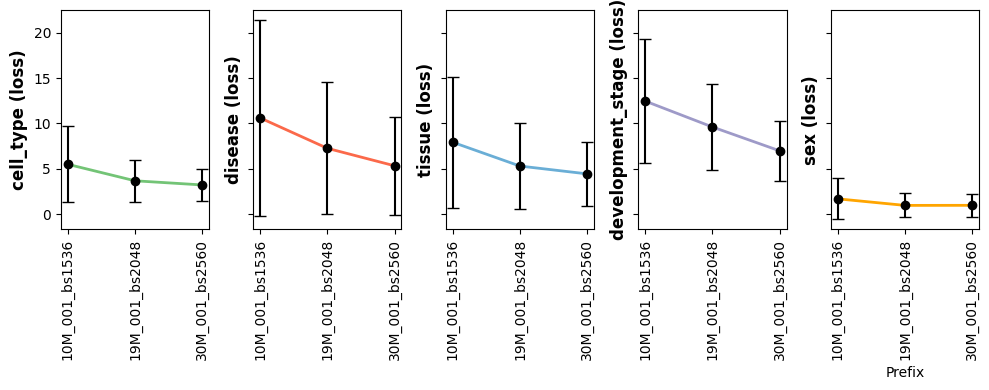

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -------------------------------
# User-specified options:
# Choose which metric to plot: 'f1', 'sensitivity', or 'specificity'
value_to_plot = 'loss'  
# Flag to select summary statistic: True uses mean/std, False uses median/IQR.
use_mean = True
_PREFIX_LIST = PREFIX_LIST[:3]
# -------------------------------

# Define metric groups and available hops.
# For 'sex', only hop 0 is available.
metric_groups = {
    'cell_type': [0],
    'disease': [0],
    'tissue': [0],
    'development_stage': [0],
    'sex': [0]
}

# Build the list of metric columns (e.g., "cell_type_hop_0_f1")
selected_metrics = []
for group, hops in metric_groups.items():
    for hop in hops:
        selected_metrics.append(f"{group}_hop_{hop}_{value_to_plot}")

# Precompute a color palette for each metric column.
palette = {}

# For cell_type: use Greens.
cell_metrics = [f"cell_type_hop_{hop}_{value_to_plot}" for hop in metric_groups['cell_type']]
n = len(cell_metrics)
for i, m in enumerate(cell_metrics):
    palette[m] = cm.get_cmap('Greens')((i + 1) / (n + 1))

# For disease: use Reds.
disease_metrics = [f"disease_hop_{hop}_{value_to_plot}" for hop in metric_groups['disease']]
n = len(disease_metrics)
for i, m in enumerate(disease_metrics):
    palette[m] = cm.get_cmap('Reds')((i + 1) / (n + 1))

# For tissue: use Blues.
tissue_metrics = [f"tissue_hop_{hop}_{value_to_plot}" for hop in metric_groups['tissue']]
n = len(tissue_metrics)
for i, m in enumerate(tissue_metrics):
    palette[m] = cm.get_cmap('Blues')((i + 1) / (n + 1))

# For development_stage: use Purples.
dev_metrics = [f"development_stage_hop_{hop}_{value_to_plot}" for hop in metric_groups['development_stage']]
n = len(dev_metrics)
for i, m in enumerate(dev_metrics):
    palette[m] = cm.get_cmap('Purples')((i + 1) / (n + 1))

# For sex: assign a fixed color (e.g., orange).
sex_metrics = [f"sex_hop_{hop}_{value_to_plot}" for hop in metric_groups['sex']]
for m in sex_metrics:
    palette[m] = 'orange'

# Melt the dataframe into long format for the selected metrics.
# Assume your original dataframe is named `df`.
df_long = df.melt(
    id_vars=['prefix', 'val_adata_id'],
    value_vars=selected_metrics,
    var_name='metric',
    value_name=value_to_plot
)
# Drop any rows with NaN values for the chosen metric.
df_long = df_long.dropna(subset=[value_to_plot])

# Determine grid size: one row per metric group, columns = max hops among groups.
n_rows = len(metric_groups)
max_cols = max(len(hops) for hops in metric_groups.values())

fig, axes = plt.subplots(1, n_rows, figsize=(2 * n_rows, 4), sharey=True)
if max_cols == 1:
    axes = axes.reshape(-1, 1)

# Loop over each metric group (row) and each hop (column).
for row_idx, (group, hops) in enumerate(metric_groups.items()):
    for col_idx in range(max_cols):
        # Turn off extra panels.
        if col_idx >= len(hops):
            axes[col_idx, row_idx].axis('off')
            continue

        hop = hops[col_idx]
        metric_name = f"{group}_hop_{hop}_{value_to_plot}"
        ax = axes[row_idx, col_idx]

        # Filter data for the current metric and drop any NaNs.
        df_metric = df_long[df_long['metric'] == metric_name].dropna(subset=[value_to_plot])

        # Compute summary statistics per prefix.
        if use_mean:
            stats = df_metric.groupby('prefix')[value_to_plot].agg(['mean', 'std']).reindex(_PREFIX_LIST)
            y_vals = stats['mean']
            y_err = stats['std']
        else:
            stats = df_metric.groupby('prefix').agg(
                median=(value_to_plot, np.median),
                q1=(value_to_plot, lambda x: x.quantile(0.25)),
                q3=(value_to_plot, lambda x: x.quantile(0.75))
            ).reindex(_PREFIX_LIST)
            y_vals = stats['median']
            y_err_lower = y_vals - stats['q1']
            y_err_upper = stats['q3'] - y_vals
            y_err = [y_err_lower.values, y_err_upper.values]

        x = np.arange(len(_PREFIX_LIST))
        # Retrieve the precomputed color (default to gray if not found).
        line_color = palette.get(metric_name, 'gray')

        # Plot black markers with error bars.
        ax.errorbar(
            x, y_vals, yerr=y_err,
            fmt='o', color='black', ecolor='black',
            capsize=4, markersize=6, linestyle='None'
        )
        # Connect the markers with a line in the precomputed color.
        ax.plot(x, y_vals, color=line_color, linestyle='-', linewidth=2)

        ax.set_xticks(x)
        ax.set_xticklabels(_PREFIX_LIST, rotation=90)
        # ax.set_ylim(0, 1)
        # Set the title to show the hop value.

        # Label the y-axis with the metric group on the leftmost panel.
        if col_idx == 0:
            ax.set_ylabel(f"{group} ({value_to_plot})", fontsize=12, fontweight='bold')
        # Label the x-axis on the bottom row.
        if row_idx == n_rows - 1:
            ax.set_xlabel('Prefix')

plt.tight_layout()
plt.show()
